In [4]:
from transformer_model import EncoderOnlyTransformerModel, EncoderDecoderTransformerModel
from dataloader import QCTempDataset, DataLoader
import numpy as np
import torch


load = False
dataset = QCTempDataset("/home/jkambulo/projects/def-rgmelko/jkambulo/data/qc-temp",
                        size=(4,4), Rb_per_a=1.2, delta_per_omega=1.1, lattice='SquareLattice', query_beta=lambda x: x==0.1)  

if load:
    transformer = EncoderOnlyTransformerModel.load("/home/jkambulo/projects/def-rgmelko/jkambulo/code/qc-temp/transformer/checkpoints/model_single_beta0_1.pt")
    # model_trained3.pt
else:
    transformer = EncoderDecoderTransformerModel(atom_grid_shape=(4,4), spin_states=2, 
                                    embedding_size=4, nhead=2,
                                    dim_feedforward=2048, nlayers=5,dropout=0, n_phys_params=1)
dl = DataLoader(dataset, batchsize=128, epochs=20, nbatches=10_000, dataset_index=None)
transformer.start_training(dl, data_file = './checkpoints/model_ed.csv', log_interval=1)

epoch   0 |     1/10000 batches | lr 0.001000 | ms/batch 12768.25 | loss 2.1671 | memory 0.39653395939693314
epoch   0 |     2/10000 batches | lr 0.001000 | ms/batch 2804.06 | loss 0.7576 | memory 0.5217720039135559
epoch   0 |     3/10000 batches | lr 0.001000 | ms/batch 2197.95 | loss 1.4666 | memory 0.5325997720485861
epoch   0 |     4/10000 batches | lr 0.001000 | ms/batch 1977.04 | loss 1.4991 | memory 0.5451992462803669
epoch   0 |     5/10000 batches | lr 0.001000 | ms/batch 1668.71 | loss 1.4837 | memory 0.5473508207512064
epoch   0 |     6/10000 batches | lr 0.001000 | ms/batch 1877.22 | loss 1.4992 | memory 0.5473508207512064
epoch   0 |     7/10000 batches | lr 0.001000 | ms/batch 1490.54 | loss 1.5049 | memory 0.5473508207512064
epoch   0 |     8/10000 batches | lr 0.001000 | ms/batch 1554.61 | loss 1.4903 | memory 0.5164599245702968
epoch   0 |     9/10000 batches | lr 0.001000 | ms/batch 1480.91 | loss 1.4717 | memory 0.5262179833638925
epoch   0 |    10/10000 batches | l

: 

: 

In [ ]:
import torch.nn as nn
class RNN(nn.Module):
    def __init__(self):
        

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
import h5py
import json
import os
import numpy as np
from typing import Optional
from itertools import product
import time


import h5py
import numpy as np
from pathlib import Path
import torch
from torch.utils import data


class QCTempDataset(Dataset):
    def __init__(
        self,
        data_path
    ):
        self.file = h5py.File(data_path, "r")
        self.length = self.file['occs'].shape[1]

    def __len__(self):
        return self.length

    def __getitem__(self, idx: int):
        return torch.tensor(self.file['occs'][:, idx], dtype=torch.int64)
    
class QCTempDataset2(Dataset):
    def __init__(
        self,
        data_path
    ):
        self.data_path = data_path
        file = h5py.File(data_path, "r")
        self.length = file['occs'].shape[1]
        file.close()

    def __len__(self):
        return self.length

    def __getitem__(self, idx: int):
        with h5py.File(self.data_path, 'r') as f:
            return torch.tensor(f['occs'][:, idx], dtype=torch.int64)
    
    
class QCTempDataset3(Dataset):
    def __init__(
        self,
        data_path
    ):
        self.data_path = data_path
        with h5py.File(self.data_path, 'r') as f:
            self.data = torch.tensor(f['occs'][:].T, dtype=torch.int32)
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx: int):
        return self.data[idx]

import queue
import asyncio
import random
import time



# async def worker(data_file, batchsize, i):
#     print(data_file)
#     try:
#         with h5py.File(data_file, "r") as f:
#             val = f['occs'][:,i*batchsize:(i+1)*batchsize]
#             print(val)
#         return val
#     except IndexError:
#         return None
        
# async def dataloader(data_file, batches, batchsize, workers=2):
#     results = asyncio.Queue()
#     i = 0
#     for i in range(workers):
#         await results.put(asyncio.create_task(worker(data_file, batchsize, i)))

#     for batch in range(batches):
#         i += 1
#         await results.put(asyncio.create_task(worker(data_file, batchsize, i)))
#         y = results.get()
#         yield y.result()
        
from multiprocessing import Queue, Process

def worker(data_file, batchsize, results, requests, seed):
    with h5py.File(data_file, "r") as f:
        np.random.seed(seed)
        index = np.arange(f['occs'].shape[1])
        np.random.shuffle(index)
        
    while True:
        i = requests.get()
        with h5py.File(data_file, "r") as f:
            sorted_index = np.sort(index[i*batchsize:(i+1)*batchsize])
            val = torch.from_numpy(f['occs'][:,sorted_index])
        results.put(val)

    
def dataloader(data_file, batches, batchsize, workers=2, seed=1234):
    results = Queue()
    requests = Queue()
    processes = []
    for i in range(workers):
        processes.append(Process(target=worker, args=(data_file, batchsize, results,requests, seed)))
        processes[-1].start()
        requests.put(i)
    
    for batch in range(batches):
        if batch + workers < batches:
            requests.put(batch)
        yield results.get()
    
    for p in processes:
        p.terminate()


# t = time.time()
# for i in range(10):
#     with h5py.File(r"/home/jkambulo/projects/def-rgmelko/jkambulo/data/qc-temp/4x4,Rb=1.20,Δ=0.50,β=0.628_data/data.jld", "r") as f:
#         torch.tensor(f['occs'][:, i*5000:(i+1)*5000])
        
# print(time.time()-t)
path = r"/home/jkambulo/projects/def-rgmelko/jkambulo/data/qc-temp/4x4,Rb=1.20,Δ=0.50,β=0.628_data/data.jld"
t = time.time()
with h5py.File(path, "r") as f:    
    for i in range(10):
        await asyncio.sleep(0.3)
        v = torch.from_numpy(f['occs'][:, i*5000:(i+1)*5000])
        x = v@v.T
        
print(time.time()-t)

print('---')
t = time.time()
with h5py.File(path, "r") as f:
    index = np.arange(f['occs'].shape[1])
    # np.random.shuffle(index)
    for i in range(50):
        torch.from_numpy(f['occs'][:, np.sort(index[i*5000:(i+1)*5000])])
        
print(time.time()-t)
print('----')
t = time.time()
total_t = time.time()
for v in dataloader(path,50, 5000, workers=32):
    print(time.time() - t)
    await asyncio.sleep(0.3)
    t = time.time()

print(time.time() - t)
print(time.time() - total_t)
# train_dataloader = DataLoader(QCTempDataset(r"/home/jkambulo/projects/def-rgmelko/jkambulo/data/qc-temp/4x4,Rb=1.20,Δ=0.50,β=0.628_data/data.jld"), batch_size=5000, shuffle=False)
# t = time.time()
# for i, v in enumerate(train_dataloader):
#     v@v.T
#     if i == 10:
#         print(time.time() - t)
#         break
    
# train_dataloader = DataLoader(QCTempDataset2(r"/home/jkambulo/projects/def-rgmelko/jkambulo/data/qc-temp/4x4,Rb=1.20,Δ=0.50,β=0.628_data/data.jld"),num_workers=32, batch_size=5000, shuffle=True)
# t = time.time()
# for i, v in enumerate(train_dataloader):
#     v@v.T
#     if i == 10:
#         print(time.time() - t)
#         break
    
# train_dataloader = DataLoader(QCTempDataset3(r"/home/jkambulo/projects/def-rgmelko/jkambulo/data/qc-temp/4x4,Rb=1.20,Δ=0.50,β=0.628_data/data.jld"),num_workers=32, batch_size=5000, shuffle=True)
# t = time.time()
# for i, v in enumerate(train_dataloader):
#     if i == 10:
#         print(time.time() - t)
#         break

3.304939031600952
---
0.5592403411865234
----
13.417811393737793
0.0029430389404296875
0.001669168472290039
0.0010869503021240234
0.0010383129119873047
0.001773834228515625
0.001836538314819336
0.001035451889038086
0.0015254020690917969
0.0017991065979003906
1.1559467315673828
0.0017418861389160156
0.0021054744720458984
1.525660514831543
0.0019392967224121094
0.002294778823852539
0.002244710922241211
0.005669832229614258
0.003436565399169922
0.0021293163299560547
0.0020542144775390625
0.0014274120330810547
0.0068149566650390625
0.002265453338623047
0.0014395713806152344
0.0017859935760498047
0.0015208721160888672
0.0015556812286376953
0.0014255046844482422
0.0017249584197998047
0.001497030258178711
0.0011031627655029297
0.0008475780487060547
0.0007228851318359375
0.0008823871612548828
0.0009510517120361328
0.0007028579711914062
0.0010077953338623047
0.0010914802551269531
0.0009093284606933594
0.0007021427154541016
0.0007421970367431641
0.0009477138519287109
0.0011653900146484375
0.0009

In [9]:
v.result()

array([[1., 0., 1., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 1., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

In [2]:
import torch
torch.cat(( torch.zeros((1,30)), torch.rand((2,30))),0)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.5073, 0.6822, 0.4937, 0.2331, 0.3670, 0.9362, 0.6008, 0.6314, 0.1524,
         0.0877, 0.7046, 0.3060, 0.5181, 0.5180, 0.6298, 0.9226, 0.0274, 0.1969,
         0.3308, 0.1613, 0.5870, 0.6963, 0.0308, 0.8357, 0.0434, 0.4417, 0.0431,
         0.5858, 0.9843, 0.7118],
        [0.6791, 0.7062, 0.5065, 0.0764, 0.7262, 0.5542, 0.5923, 0.0218, 0.7351,
         0.0936, 0.1851, 0.7877, 0.0397, 0.7194, 0.1732, 0.5113, 0.2463, 0.1791,
         0.3615, 0.5938, 0.6970, 0.2516, 0.7619, 0.5491, 0.9253, 0.2668, 0.4826,
         0.7311, 0.2405, 0.2366]])

In [2]:
transformer(torch.randint(0,1,(16,1)),torch.tensor([0.6]).unsqueeze(1))

tensor([[[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]],

        [[nan, nan]]], grad_fn=<LogSoftmaxBackward0>)

In [19]:
dataset.datasets[0][:]

IndexError: list index out of range

In [16]:
import time
for i in dl.shuffle_order[0][:128]:
    t = time.time()
    dataset.datasets[0][:,i]
    print(i, time.time()-t)

151936 0.0005340576171875
393787 3.0071983337402344
440607 0.0004112720489501953
456785 0.00026535987854003906
501408 0.0002257823944091797
979121 0.0002110004425048828
1000093 0.00024080276489257812
1058916 0.00022029876708984375
1160171 0.00022792816162109375
1178498 0.00020837783813476562
1271712 0.00021338462829589844
1369988 0.17809438705444336
1432648 0.0002837181091308594
1593750 0.0002639293670654297
1619677 0.0002288818359375
1641585 0.00026154518127441406
1932054 0.00024056434631347656
2237453 0.0002257823944091797
2285101 0.0002186298370361328
2295124 1.1619150638580322
2355954 0.0004761219024658203
2372238 0.0002162456512451172
2421648 0.00021195411682128906
2704408 0.00022172927856445312
2720924 0.00023794174194335938
2748906 0.0002219676971435547
2757950 0.00021457672119140625
2931150 0.3632035255432129
3021630 0.0005185604095458984
3039802 0.00025963783264160156
3106533 0.0002295970916748047
3115897 0.0002155303955078125
3125007 0.0002143383026123047
3184901 0.0002405643

In [2]:
from dataloader import QCTempDataset
delta = 1.1
rb = 1.2
dataset = QCTempDataset("/home/jkambulo/projects/def-rgmelko/jkambulo/data/qc-temp",
                        size=(4,4), Rb_per_a=rb, delta_per_omega=delta, lattice='SquareLattice')  

11x11,Rb=1.10,Δ=3.50,β=0.010_CornerSquareLatticedata
opened
11x11,Rb=1.10,Δ=3.50,β=0.120_CornerSquareLatticedata
opened
11x11,Rb=1.10,Δ=3.50,β=0.230_CornerSquareLatticedata
opened
11x11,Rb=1.10,Δ=3.50,β=0.340_CornerSquareLatticedata
opened
11x11,Rb=1.10,Δ=3.50,β=0.450_CornerSquareLatticedata
opened
11x11,Rb=1.10,Δ=3.50,β=0.560_CornerSquareLatticedata
opened
11x11,Rb=1.10,Δ=3.50,β=0.670_CornerSquareLatticedata
opened
11x11,Rb=1.10,Δ=3.50,β=0.780_CornerSquareLatticedata
opened
11x11,Rb=1.10,Δ=3.50,β=0.890_CornerSquareLatticedata
opened
11x11,Rb=1.10,Δ=3.50,β=1.000_CornerSquareLatticedata
opened
16x16,Rb=1.2,Δ=1.1,β=0.1310344827586207_data
opened
16x16,Rb=1.2,Δ=1.1,β=0.16206896551724137_data
opened
16x16,Rb=1.2,Δ=1.1,β=0.19310344827586207_data
opened
16x16,Rb=1.2,Δ=1.1,β=0.1_data
opened
16x16,Rb=1.2,Δ=1.1,β=0.22413793103448276_data
opened
16x16,Rb=1.2,Δ=1.1,β=0.25517241379310346_data
opened
16x16,Rb=1.2,Δ=1.1,β=0.28620689655172415_data
opened
16x16,Rb=1.2,Δ=1.1,β=0.2_data
opened
16x16,Rb=

In [2]:

from torch.profiler import profile, record_function, ProfilerActivity
import torch
import numpy as np

from transformer_model import compute_energy, int_to_binary,compute_all_probabilities
from dataloader import QCTempDataset


with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("load"):
        # print(len(dataset.beta))
        natoms = 16
        f = lambda x: np.sum(x*(2**np.arange(natoms))[None], axis=1)

        i_values = 60
        energy_values = np.zeros((i_values, 3)) # 0 = transformer, 1 = data, 2 = exact
        beta = dataset.beta[:i_values]
        
    for i in range(1,2):
        print(i)
        # with record_function('histogram'):
        #     val, bins = np.histogram(f(dataset.datasets[i][:].T), bins=np.arange(2**natoms+1))
        #     logp = torch.from_numpy(np.log(val/np.sum(val)))
        with record_function('int_to_binary'):
            total_configs = int_to_binary(torch.arange(2**natoms), natoms)
        with record_function('compute_energy'):
            # energy_values[i,1] = compute_energy(total_configs, logp, {'omega':25.132741228718345, 'delta_per_omega':1.1, 'rb_per_a':1.2},atoms=natoms)
            energy_values[i,2] = dataset.energy[i]

        total_configs, prob = compute_all_probabilities(transformer,phys_params=torch.tensor([beta[i]]))
        energy_values[i,0] = compute_energy(total_configs, prob, {'omega':25.132741228718345, 'delta_per_omega':1.1, 'rb_per_a':1.2})
        del total_configs, prob
        

1


In [13]:
import torch
from transformer_model import compute_energy, int_to_binary,compute_all_probabilities
natoms = 16
p = torch.rand(2**natoms)
compute_energy(int_to_binary(torch.arange(2**natoms), natoms), torch.log(p/torch.sum(p)),{'omega':25.132741228718345, 'delta_per_omega':1.1, 'rb_per_a':1.2})


102.88931274414062

In [3]:
print(beta)
energy_values

[0.1, 1.0]


array([[   0.        ,    0.        ,    0.        ],
       [-203.91567993,    0.        , -224.851     ],
       [   0.        ,    0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ],
       [   0.        ,    0.

In [2]:
import pandas as pd
import numpy as np
pd.DataFrame({'a':np.array([1,2,3]),'b':np.array([3,4,5])})

,a,b
0,1,3
1,2,4
2,3,5


In [6]:
print(prof.key_averages().table(sort_by="self_cpu_time_total", row_limit=30))

-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                         Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                     aten::mm        47.00%        7.752s        47.01%        7.753s       5.340ms          1452  
              aten::clamp_min        27.71%        4.571s        55.38%        9.134s      13.839ms           660  
                   aten::add_        12.09%        1.994s        12.13%        2.001s       1.083ms          1848  
               aten::_softmax         2.61%     430.925ms         2.61%     430.925ms       1.306ms           330  
                    aten::bmm         1.92%     316.324ms         1.95%     322.407ms     488.495us           660  
                  aten::copy_         1.76%     291.044ms         1.77% 

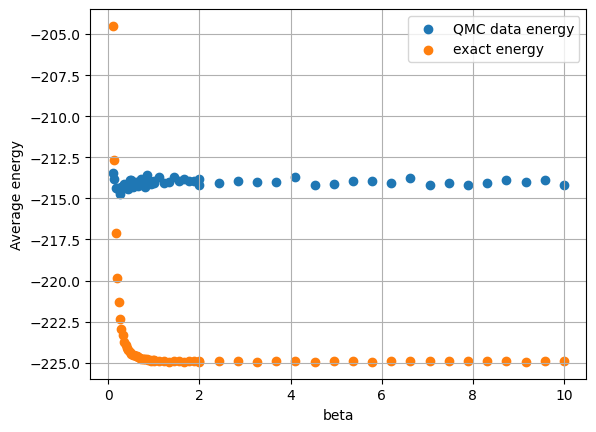

In [10]:
import matplotlib.pyplot as plt
# plt.plot(beta[::3], energy_values[:-6:3,0], label='Transformer energy')
plt.scatter(beta, energy_values[:,1], label='QMC data energy')
plt.scatter(beta, energy_values[:,2], label='exact energy')
plt.xlabel("beta")
plt.ylabel('Average energy')
plt.legend()
plt.grid()
plt.show()

In [2]:
sum(p.numel() for p in transformer.parameters())


36175

In [14]:
import psutil
psutil.virtual_memory()

svmem(total=134783528960, available=60258820096, percent=55.3, used=57206939648, free=4383371264, active=74130350080, inactive=38517624832, buffers=53399552, cached=73139818496, shared=16763404288, slab=13912907776)

In [5]:
transformer.eval()
batchsize = 1000
experiments = 16
prob = np.zeros((29,experiments))
j = 14    
tmp = dataset.datasets[j][:]
for k in range(experiments):
    np.random.shuffle(tmp)
    data = torch.from_numpy(tmp[:,:batchsize]).type(torch.int64)
    for i in range(0,29):
        output = transformer(data, phys_params=torch.tensor([[dataset.beta[i]]*batchsize]))
        output *= torch.nn.functional.one_hot(data, num_classes=2)
        prob[i,k] = torch.sum(output).item()
    


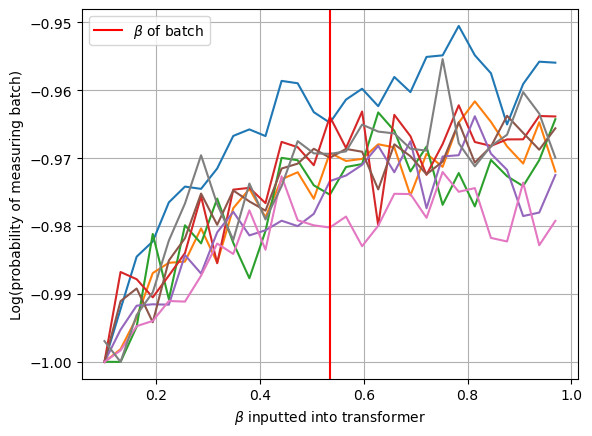

In [33]:
import matplotlib.pyplot as plt

# plt.plot(dataset.beta, prob)
# plt.plot(dataset.beta, -prob/np.min(prob, axis=0)[None])
# # plt.plot(dataset.beta, np.mean(prob,axis=1), label='Average probability over multiple batches')
# plt.axvline(x=dataset.beta[j],c='r',label=r'$\beta$ of batch')
# plt.xlabel(r"$\beta$ inputted into transformer")
# plt.ylabel("Log(probability of measuring batch)")
# plt.legend()
# plt.grid()
# plt.show()

# plt.plot(dataset.beta, prob)
plt.plot(dataset.beta, -prob2/np.min(prob2, axis=0)[None])
# plt.plot(dataset.beta, np.mean(prob,axis=1), label='Average probability over multiple batches')
plt.axvline(x=dataset.beta[j],c='r',label=r'$\beta$ of batch')
plt.xlabel(r"$\beta$ inputted into transformer")
plt.ylabel("Log(probability of measuring batch)")
plt.legend()
plt.grid()
plt.show()

In [2]:
def compute_histograms(dataset: QCTempDataset, dataset_slice=slice(None), filter_data=slice(None), atoms=None):
    natoms = atoms if atoms else dataset.get_natoms()
    f = lambda x: np.sum(x*(2**np.arange(natoms))[None], axis=1)
    data_list = dataset.datasets[dataset_slice]
    beta_list = dataset.beta[dataset_slice]
    order_param_list = dataset.order_param[dataset_slice]
    ncomb = 2**natoms

    bins = np.arange(ncomb)
    hist_list = [np.histogram(f(data[:][filter_data].T), bins=bins)[0] for data in data_list]        
    index_commonality = [np.argsort(hist) for hist in hist_list]
    order_params, op_counts = zip(*[np.unique(order_param, return_counts=True) for order_param in order_param_list])
    magnetization = [np.sum(data[filter_data],axis=0) for data in data_list]
    average_magnetization = [np.mean(mag) for mag in magnetization]
    std_av_magnetization = [np.std(mag)/np.sqrt(len(mag)-1) for mag in magnetization]
    return (bins, hist_list), (order_params[0], op_counts), (average_magnetization, std_av_magnetization), index_commonality, beta_list 

(bins, hist_list), (op, op_counts), (average_magnetization, std_av_magnetization), index_commonality, beta_list  = compute_histograms(dataset,)

KeyboardInterrupt: 

In [3]:
f = lambda x: np.sum(x*(2**np.arange(16))[None], axis=1)

data1 = f(dataset.datasets[0][:].T)
_, index, count = np.unique(data1, return_index=True, return_counts=True)
sorted_index1 = np.argsort(index)
data1 = dataset.datasets[0][:, index[sorted_index1]]

count1, bins  = np.histogram(f(dataset.datasets[0][:].T), bins=np.arange(2**16))
count2, _ = np.histogram(f(dataset.datasets[-1][:].T), bins=np.arange(2**16))

In [2]:
batchsize = 1000
prob2 = np.zeros((len(count), 2))

for k in [0,-1]:
    i = 0
    while batchsize*i < len(count):
        tmp  = torch.from_numpy(data1[:,batchsize*i:batchsize*(i+1)]).type(torch.int64)
        output = transformer(tmp, phys_params=torch.tensor([[dataset.beta[k]]*tmp.shape[1]]))
        output *= torch.nn.functional.one_hot(tmp, num_classes=2)
        prob2[batchsize*i:batchsize*(i+1),k] = torch.sum(output, axis=(0,2)).detach().numpy()
        i += 1


NameError: name 'count' is not defined

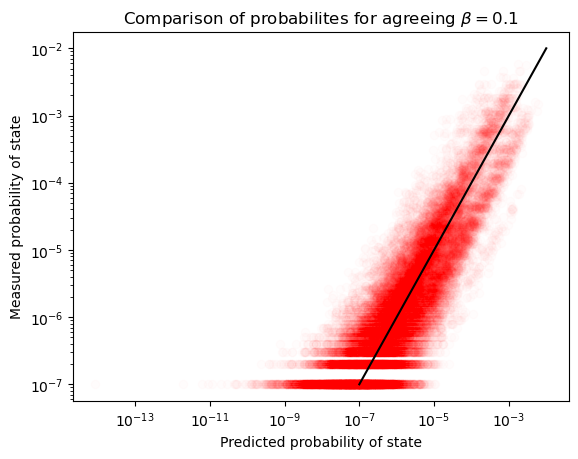

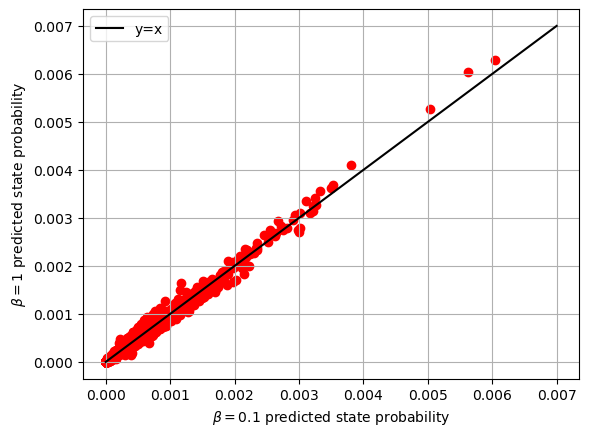

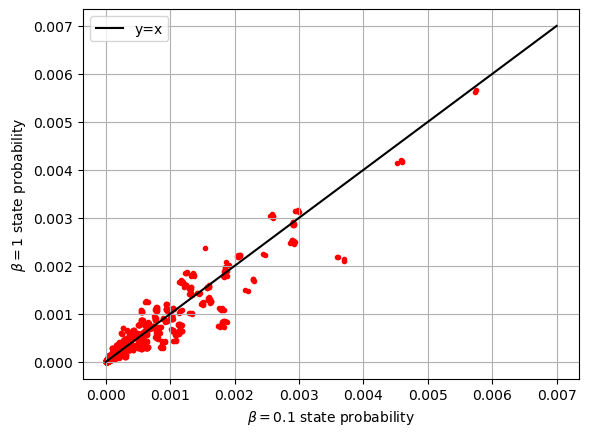

In [60]:
import matplotlib.pyplot as plt
plt.scatter(np.exp(prob2[:,0]), count[sorted_index1]/1e7, c='r',alpha=0.01)
# plt.scatter(np.exp(prob2[:,10]), count[sorted_index]/1e7, c='g',alpha=0.01,)
# plt.scatter(np.exp(prob2[:,20]), count[sorted_index]/1e7, c='b', alpha=0.01)
plt.plot([1e-7, 1e-2],[1e-7,1e-2], c='k')
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Predicted probability of state")
plt.ylabel("Measured probability of state")
plt.title(r"Comparison of probabilites for agreeing $\beta=0.1$")
plt.show()

plt.scatter(np.exp(prob2[:,0]), np.exp(prob2[:,1]), c='r')
plt.plot([1e-7, 7e-3],[1e-7,7e-3], c='k', label='y=x')
plt.xlabel(r"$\beta=0.1$ predicted state probability")
plt.ylabel(r"$\beta=1$ predicted state probability")
plt.legend()
plt.grid()
plt.show()

plt.scatter(count1/1e7, count2/1e7, c='r',marker='.')
plt.plot([1e-7, 7e-3],[1e-7,7e-3], c='k', label='y=x')
plt.xlabel(r"$\beta=0.1$ state probability")
plt.ylabel(r"$\beta=1$ state probability")
plt.legend()
plt.grid()

In [11]:
import torch
transformer.eval()
x = [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]
spins = torch.tensor([x]).T
print(spins.reshape((4,4)))
dataset_index = 0
print('beta',dataset.beta[dataset_index])
phys_params = torch.tensor([[dataset.beta[dataset_index]]])
p = transformer(spins, phys_params=phys_params)
print('output')
print(p.exp())
print('pred', torch.sum(p*torch.nn.functional.one_hot(spins, num_classes=2)).exp())
print('true', torch.sum(torch.all(torch.from_numpy(dataset.datasets[dataset_index][:]) == spins, axis=0))/1e6)

tensor([[1, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 1]])
beta 0.1
output
tensor([[[0.5225, 0.4775]],

        [[0.9571, 0.0429]],

        [[0.5947, 0.4053]],

        [[0.4267, 0.5733]],

        [[0.9350, 0.0650]],

        [[0.6180, 0.3820]],

        [[0.7957, 0.2043]],

        [[0.4936, 0.5064]],

        [[0.6866, 0.3134]],

        [[0.7326, 0.2674]],

        [[0.7194, 0.2806]],

        [[0.6950, 0.3050]],

        [[0.4679, 0.5321]],

        [[0.4568, 0.5432]],

        [[0.7869, 0.2131]],

        [[0.6703, 0.3297]]], grad_fn=<ExpBackward0>)
pred tensor(0.0004, grad_fn=<ExpBackward0>)
true tensor(0.0027)


In [12]:
dataset.beta[29]

1.0